In [2]:
#Test notebook for tracking rigid body  marker consisting of multiple fiducials within a CT scan volume

#3D data processing
import open3d as o3d
import ct_tracking_library # our helper functions
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
from ipywidgets import interact, fixed

#our processing code
from ct_tracking_library.ct_motor_functions import *
from ct_tracking_library.ct_tracking_functions import *
from ct_tracking_library.ct_processing_functions import *
from ct_tracking_library.ct_display_functions import *
from ct_tracking_library.ct_object_classes import *

#used for GUI
%matplotlib notebook

#find transform
import transforms3d as t3d
import datetime
import time
import pickle

## Motor Functions

### zero on the center, user enter the startng postion in degree

In [2]:
c = moteus.Controller()

## Setup the Motor

User input: millimeters (because thats easier to think about than meters)
Motor motions: radians, radian/s, etc. (because thats is an SI type unit)
Actuator motions: millimeters (because thats an SI type unit)
Transforms: radians and millimeters because thats always pretty much they use

#### Run the code below to check the motor each Test

Enter the number of loop5


<IPython.core.display.Javascript object>


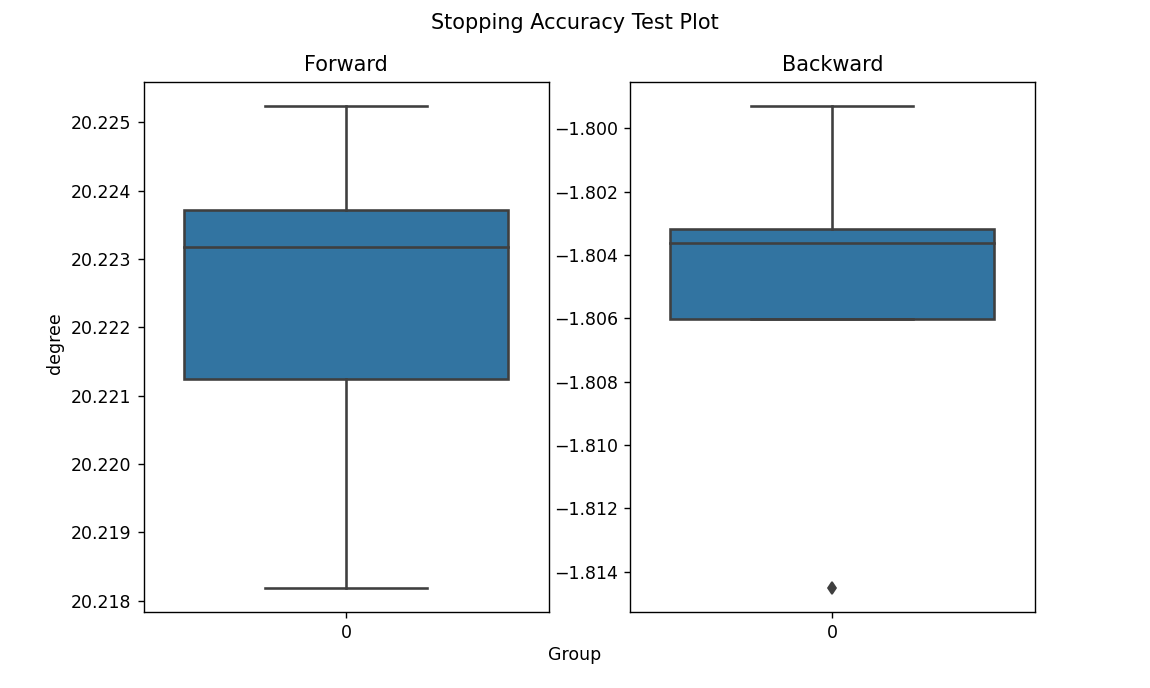

begin zeroing
Initial Starting Degree:  3218.95
begin zeroing
Initial Starting Degree:  3218.31
begin zeroing
Initial Starting Degree:  3217.82
begin zeroing
Initial Starting Degree:  3218.62
begin zeroing
Initial Starting Degree:  3218.71
begin zeroing
Initial Starting Degree:  -287.05
begin zeroing
Initial Starting Degree:  -287.44
begin zeroing
Initial Starting Degree:  -286.37
begin zeroing
Initial Starting Degree:  -286.98
begin zeroing
Initial Starting Degree:  -288.79


In [3]:
n = input('Enter the number of loop')
d1,d2 = await stopping_acc_test(c,int(n))

## Let's Start the Test

### First, home the motor and save the initial position(radian,shows in degree)

### Run the CT scan for checking the postion error later.

### Once get the intial starting postion, run the testing function with the desired postion, and then run the CT scanner once motor moved.

In [5]:
data_p_list = []
data_degree_list = []

In [132]:
await def run_motor(c,ip=None,old_uds=None):
    """
    This function let user inputs a postion in mm and save the motor joint postion in the input list:

    Args:
        c: the moteus motor object.
        ip(float): intial rev postion value for the motor.
        v (float): the verlocity for the motor to move in rad/s.
        torque (float): the maximum torque for the motor.

    Returns:
        float: the "home" position in radians

    """
    ratio = 0.5040628051757813 #converting mm to rev
    if ip is None:
        ip = await motor_zero(c,stop_torque=.1,v=1)
    print("Initial Starting Radian: ", ip*(2*math.pi))
    uds = int(input('Enter the desired postion in mm (0-127): '))
    if i == 0:
        old_uds = uds
    else:
        
        
    if uds >= data_degree_list[-2]:
        currcent_p_list,p_mm = await one_axis_farward(c,ip,user_desried=uds*ratio)
    else:
        currcent_p_list,p_mm = await one_axis_backward(c,ip,user_desried=uds*ratio)
    data_p_list.append(currcent_p_list)
    p_mm = p_mm/ratio
    return p_mm,ip

Enter the desired postion in mm (0-127): 0


### stop the motor

In [154]:
await read_p()

Begain Testing
Position: -4.7491302490234375
Position in Degree:  -272.11


-4.7491302490234375

### Saving the result

In [153]:
with open('position.pkl', 'wb') as f:
    pickle.dump(data_p_list, f)
with open('degree.pkl', 'wb') as f:
    pickle.dump(data_degree_list, f)
with open('time.pkl', 'wb') as f:
    pickle.dump(data_time_list, f)

#### python -m moteus_gui.tview --devices=1

## Feltch the DICOM file from server

### Goto the website:  http://unicorn2.ucsd.edu:8080/dcm4chee-arc/ui2/#/study/patient

### Selected Series on the top tabs

### On the left hand side input: DIMITRI07041995 as the Patient ID

### In the middle section select Newest Frist in the Order by Tab

### In the middle section select DCM4CHEE in the Web App Service Tab and CLICK Sumbit

### Download the 1st row by clicking the 3 dots symbol and downolad it

### Once Downloaded, extract the DICOM files ONLY to the following folder: ./test_data/DICOM

In [7]:
data = {}
s_num = 0

## Processing DICOM file

In [13]:
def DICOM_series_dropdown_callback(series_to_load, series_dictionary):
    global selected_series
               # Print some information about the series from the meta-data dictionary
               # DICOM standard part 6, Data Dictionary: http://medical.nema.org/medical/dicom/current/output/pdf/part06.pdf
    file_reader.SetFileName(series_dictionary[series_to_load][0])
    file_reader.ReadImageInformation()
    tags_to_print = {'0010|0010': 'Patient name: ', 
                     '0008|0060' : 'Modality: ',
                     '0008|0021' : 'Series date: ',
                     '0008|0080' : 'Institution name: ',
                     '0008|1050' : 'Performing physician\'s name: '}
    for tag in tags_to_print:
        try:
            print(tags_to_print[tag] + file_reader.GetMetaData(tag))
        except: # Ignore if the tag isn't in the dictionary
            pass
    selected_series = series_to_load

### Select the desired DICOM file

In [135]:
time = datetime.datetime.now()
time = time.strftime("%m/%d/%y %I:%M%p")

In [14]:
data_directory = "./test_data/DICOM"
# Global variable 'selected_series' is updated by the interact function
selected_series = ''
file_reader = sitk.ImageFileReader()         
# Directory contains multiple DICOM studies/series, store
# in dictionary with key being the series ID
series_file_names = {}
series_IDs = sitk.ImageSeriesReader_GetGDCMSeriesIDs(data_directory)
            # Check that we have at least one series
if series_IDs:
    for series in series_IDs:
        series_file_names[series] = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(data_directory, series)
    
    interact(DICOM_series_dropdown_callback, series_to_load=list(series_IDs), series_dictionary=fixed(series_file_names)); 
else:
    print('Data directory does not contain any DICOM series.')

interactive(children=(Dropdown(description='series_to_load', options=('1.2.840.113619.2.416.148220411494716321…

### Pick target marker postion

In [6]:
def func1(target_marker_select):
    global target_marker_name
    target_marker_name = target_marker_select

In [7]:
output = interact(func1, target_marker_select=['fixed_marker_crane', 'moving_marker_crane', 'moving_marker_1_DoF','fixed_marker_1_DoF'])

interactive(children=(Dropdown(description='target_marker_select', options=('fixed_marker_crane', 'moving_mark…

In [27]:
if target_marker_name == 'fixed_marker_crane':
    marker = np.load('./test_data/marker1.npy')
    R =  t3d.euler.euler2mat(np.pi/4+0.1, 0, -np.pi/6-0.2)@t3d.euler.euler2mat(0,0.6,0)# @ t3d.euler.euler2mat(0, np.pi/8, 0)
    marker = (R.T@marker.T).T
    crop_z = None
    #zero mean the marker since we place the rigid body at the mean here
    marker = marker - marker.mean(axis=0) - np.array([2,0,0])
if target_marker_name == 'moving_marker_crane':
    marker = np.array([[-10,-5,0],[-10,5,0],[0,-5,0],[10,0,0]])
    R = np.eye(3)
    crop_z = None

if target_marker_name == 'moving_marker_1_DoF':
    marker = np.array([[-10,-5,0],[-10,5,0],[0,-5,0],[10,0,0]])
    R = np.eye(3)
    crop_z = None

if target_marker_name == 'fixed_marker_1_DoF':
    marker = np.array([[0,-14,0],[0,-6,0],[0,16,0],[17,0,0]])
    R = np.eye(3)
    crop_z = [160,254]

In [9]:
print('Our marker: \n {}'.format(marker))

Our marker: 
 [[  0 -14   0]
 [  0  -6   0]
 [  0  16   0]
 [ 17   0   0]]


### Convert DICOM files

In [15]:
#convert scan to mesh for finding markers via thresholding
scan_file = series_file_names[selected_series]
convert_scan_to_mha(scan_file, crop_z = crop_z)
convert_mha_to_mesh(output_mesh_file = 'temp_mesh.obj')

spacing:  [0.63 0.7  0.7 ]
 origin:  [ -49.69 -180.   -180.  ]


### Disaply DICOM file (Left and Right are the SAME)

origin: (-180.0, -180.0, -149.688)
size: (512, 512, 256)
spacing: (0.703125, 0.703125, 0.6250039215686274)
direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
pixel type: 32-bit signed integer
number of pixel components: 1

origin: (-180.0, -180.0, -149.688)
size: (512, 512, 256)
spacing: (0.703125, 0.703125, 0.6250039215686274)
direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
pixel type: 32-bit signed integer
number of pixel components: 1



<IPython.core.display.Javascript object>


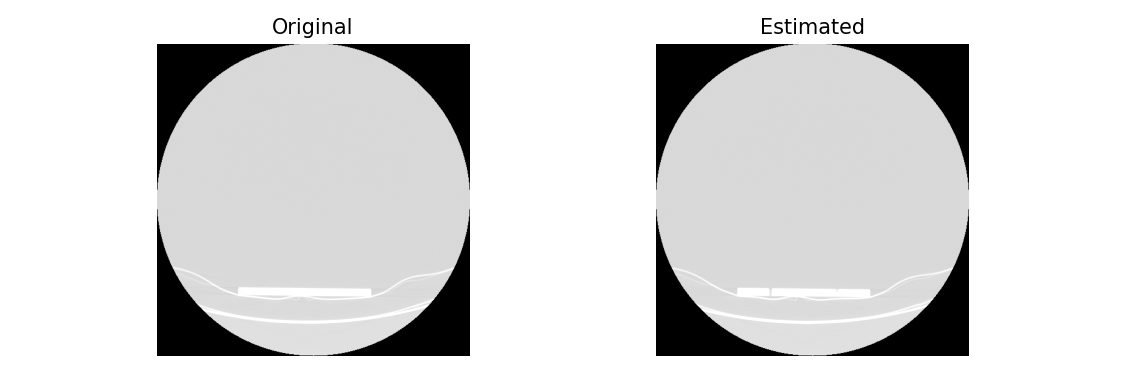

In [16]:
display_Dicom("temp_mesh.mha","temp_mesh.mha")

### Once the Imag above looks right, run the following code the find the neede error and transform

In [28]:
#find candidate fiducials within the scanner returning clustered centroids that could be rigid body markers
_, marker_centroid_coordinates, pcd_selected, marker_mesh, _, good_centroid_clusters = find_candidate_centroids(marker = marker, debug=False)

print('marker centroid coordinates from design: {}'.format(marker))
print('found centroid coordinates: {}'.format(marker_centroid_coordinates))

#display candidate fiducials
o3d.visualization.draw_geometries([pcd_selected, marker_mesh])

[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=22
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 177.77it/s]


[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
[0 1 2 3]
[4 5 6 7]
marker centroid coordinates from design: [[  0 -14   0]
 [  0  -6   0]
 [  0  16   0]
 [ 17   0   0]]
found centroid coordinates: [[-41.13  33.84  -9.04]
 [-40.43  17.77   8.09]]


## Find marker

In [29]:
#find best transform and marker from candidate fiducials
tracked_R, tracked_t, permuted_centroids, min_error = find_best_transform_from_candidate_marker_clusters(marker, good_centroid_clusters)

#get rid of column of ones to make 3xN
permuted_centroids = permuted_centroids[:3,:].T

#transform marker geometry coordinates using found transform to tracked image coordinates
transformed_marker = (tracked_R @ marker.T + tracked_t).T
error = permuted_centroids-transformed_marker

[0.15 5.79]
Everything looks good!
the final error is:  0.15121874801590013


## Visualize Marker

In [30]:
#create o3d visualizations
marker_3d_tracked = create_marker_visualization(fiducial_coordinates=permuted_centroids, color=[0.8, 0.2, 0.2])
marker_3d_base = create_marker_visualization(marker, [0.2, 0.8, 0.2])
marker_3d_base.append(create_coordinate_frame_visualization())
marker_3d_transformed = create_marker_visualization(marker, [0.2, 0.2, 0.8], tracked_R, tracked_t)
marker_3d_transformed.append(create_coordinate_frame_visualization(tracked_R, tracked_t))

#display tracked  markers and coordinate frames
# o3d.visualization.draw_geometries(marker_3d_tracked)
# o3d.visualization.draw_geometries(marker_3d_base)
# o3d.visualization.draw_geometries(marker_3d_transformed)

#tracking error from final transform
np.set_printoptions(2)
print("Error (mm): {}".format(error))
print("Error norm (mm): {}".format(np.linalg.norm(error)**0.5))

#visualize tracked markers on top of mesh used for tracking
visualization_list2 = marker_3d_tracked+marker_3d_base+marker_3d_transformed + [marker_mesh]
visualization_list1 = copy.deepcopy(visualization_list2)
o3d.visualization.draw_geometries(visualization_list2)

Error (mm): [[-9.13e-02 -1.62e-01  1.14e-02]
 [ 1.33e-01 -2.73e-02 -2.83e-02]
 [-4.16e-02  1.89e-01 -2.88e-03]
 [ 1.33e-04  1.31e-04  1.98e-02]]
Error norm (mm): 0.5499431752752281
[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


### Create Marker object

In [149]:
append_value(data, "scan"+str(s_num), Marker(time,target_marker_name,selected_series,marker,t2T(tracked_R, tracked_t/1000),np.linalg.norm(error)**0.5))

## Visualize tracked markers and full scan w/ low threshold

In [19]:
convert_scan_to_mha(scan_file)
convert_mha_to_mesh(output_mesh_file = 'temp_full_mesh.obj', threshold_value = -400)
temp_full_mesh = o3d.io.read_triangle_mesh('temp_full_mesh.obj').paint_uniform_color([0.0, 0.0, 0.8]).compute_vertex_normals()
o3d.visualization.draw_geometries(visualization_list2+visualization_list1+[temp_full_mesh])

spacing:  [0.63 0.7  0.7 ]
 origin:  [-149.69 -180.   -180.  ]
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


# Run for the other move/fix marker than run the following code

In [150]:
append_value(data, "scan"+str(s_num),Robot(time,ratio,p_mm,uds,d1,d2))
s_num += 1

In [151]:
data

{'scan0': [Marker(moving_marker_1_DoF:22/08/10 06:53PM),
  Marker(fixed_marker_1_DoF:22/08/10 06:53PM),
  Robot(22/08/10 06:53PM)],
 'scan1': [Marker(moving_marker_1_DoF:22/08/10 06:59PM),
  Marker(fixed_marker_1_DoF:22/08/10 06:59PM),
  Robot(22/08/10 06:59PM)],
 'scan2': [Marker(moving_marker_1_DoF:22/08/10 07:05PM),
  Marker(fixed_marker_1_DoF:22/08/10 07:05PM),
  Robot(22/08/10 07:05PM)],
 'scan3': [Marker(moving_marker_1_DoF:22/08/10 07:13PM),
  Marker(fixed_marker_1_DoF:22/08/10 07:13PM),
  Robot(22/08/10 07:13PM)],
 'scan4': [Marker(moving_marker_1_DoF:22/08/10 07:18PM),
  Marker(fixed_marker_1_DoF:22/08/10 07:18PM),
  Robot(22/08/10 07:18PM)],
 'scan5': [Marker(moving_marker_1_DoF:22/08/10 07:23PM),
  Marker(fixed_marker_1_DoF:22/08/10 07:23PM),
  Robot(22/08/10 07:23PM)],
 'scan6': [Marker(moving_marker_1_DoF:22/08/10 07:33PM),
  Marker(fixed_marker_1_DoF:22/08/10 07:33PM),
  Robot(22/08/10 07:33PM)]}

In [152]:
# save data for later use
with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)
await read_p()

Begain Testing
Position: -4.7491912841796875
Position in Degree:  -272.11


-4.7491912841796875

## Load the data back

In [155]:
with open('data.pkl', 'rb') as f:
    data_load = pickle.load(f)
print(data_load['scan0'])

[Marker(moving_marker_1_DoF:22/08/10 06:53PM), Marker(fixed_marker_1_DoF:22/08/10 06:53PM), Robot(22/08/10 06:53PM)]


In [174]:
data_load['scan1'][0].time

'22/08/10 06:59PM'

In [175]:
Me_list = []
Fe_list = []
TT_list = []
for x in data_load:
        Me_list.append(data_load[x][0].error)
        Fe_list.append(data_load[x][1].error)
        TT_list.append(data_load[x][0].time)

<IPython.core.display.Javascript object>


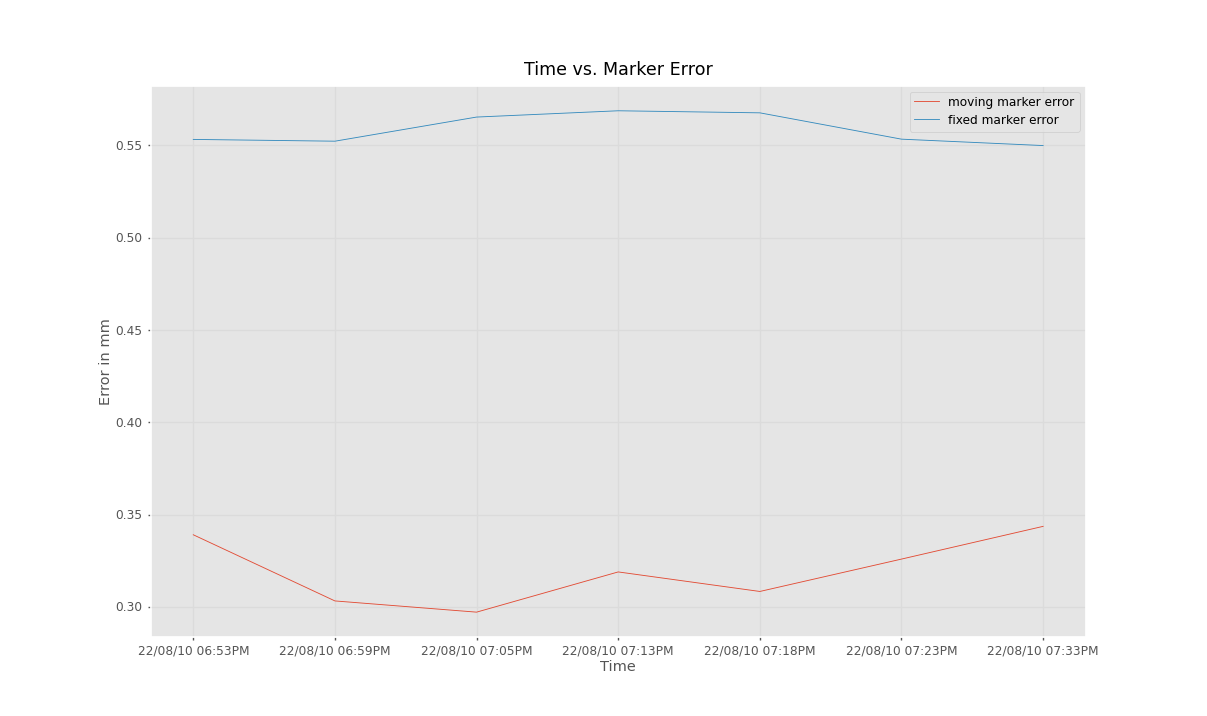

In [185]:
plt.plot(TT_list,Me_list)
plt.plot(TT_list,Fe_list)
plt.ylabel('Error in mm')
plt.xlabel('Time')
plt.legend(["moving marker error","fixed marker error"])
plt.title("Time vs. Marker Error")
plt.show()

## forward kinematics

In [156]:
from spatialmath import *
from roboticstoolbox import ET as E

In [157]:
Tm = SE3(data_load['scan0'][0].T)
Tfix = SE3(data_load['scan0'][1].T)

<IPython.core.display.Javascript object>


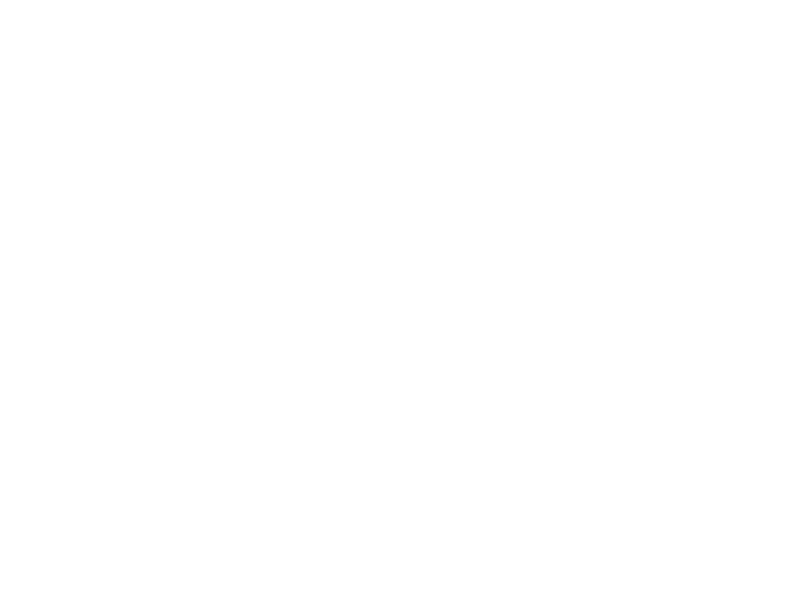

<IPython.core.display.Javascript object>


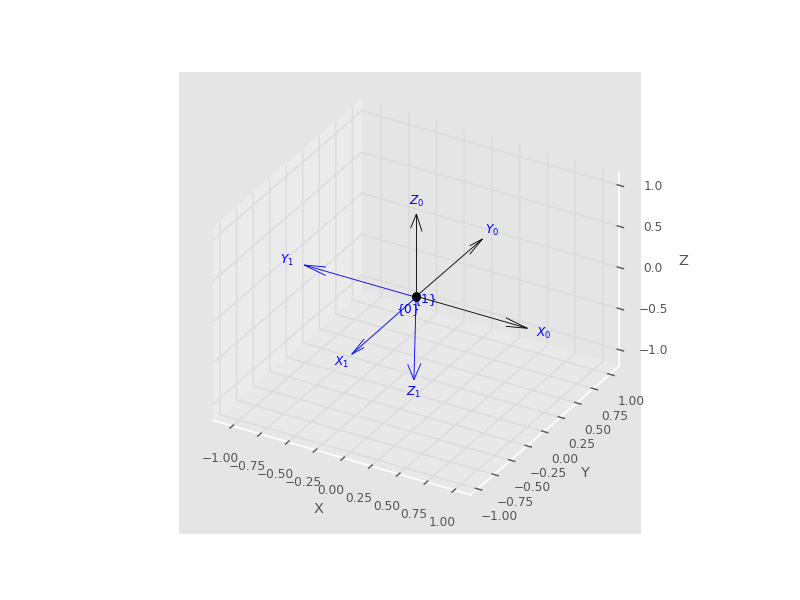

In [158]:
plt.figure() # create a new figure
SE3().plot(frame='0', color='black')
Tm.plot(frame='1')

In [160]:
e = E.tx(.04)*E.ty(-.024)*E.tz(.0235)*E.tz()
e = e*E.Ry(90, 'deg')*E.Rz(-90, 'deg')

In [162]:
Tfixi = Tfix.inv()
Tfk = SE3(e.eval([1]))
Tfk2 = Tfixi*Tfk

<IPython.core.display.Javascript object>


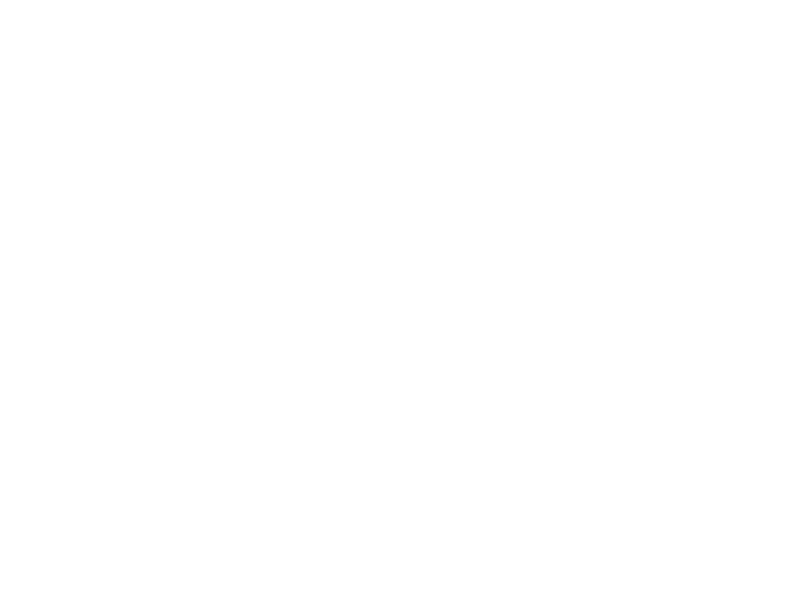

<IPython.core.display.Javascript object>


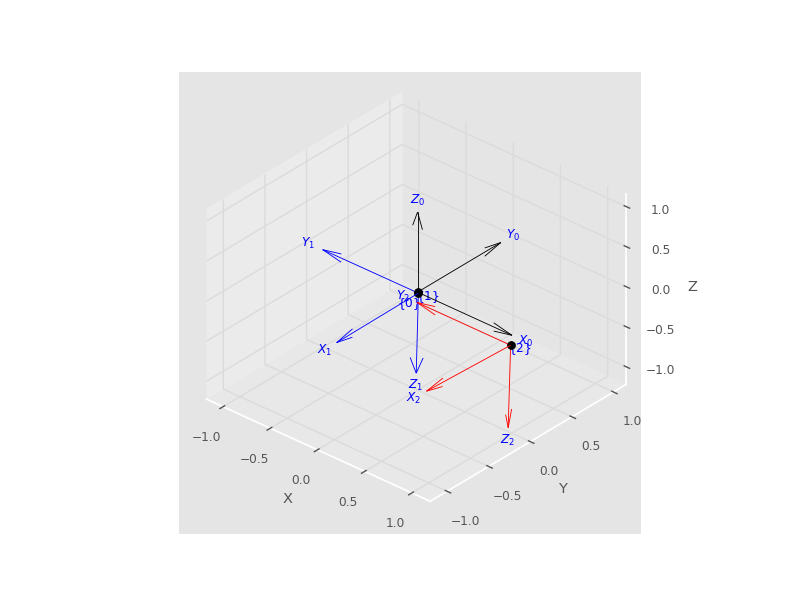

In [163]:
plt.figure() # create a new figure
SE3().plot(frame='0', color='black')
Tm.plot(frame='1',color='blue')
Tfk2.plot(frame='2',color='red')

In [198]:
offset = data_load['scan0'][2].joint_postion

In [234]:
Tbase = SE3(data_load['scan1'][1].T)
Tee = SE3(data_load['scan1'][0].T)
Tfinal = Tbase.inv()*Tee
e = E.tx(.04)*E.ty(-.024)*E.tz(.0235)*E.tz()
e = e*E.Ry(90, 'deg')*E.Rz(-90, 'deg')
Tfk = Tbase.inv()*SE3(e.eval([data_load['scan1'][2].joint_postion]))

<IPython.core.display.Javascript object>


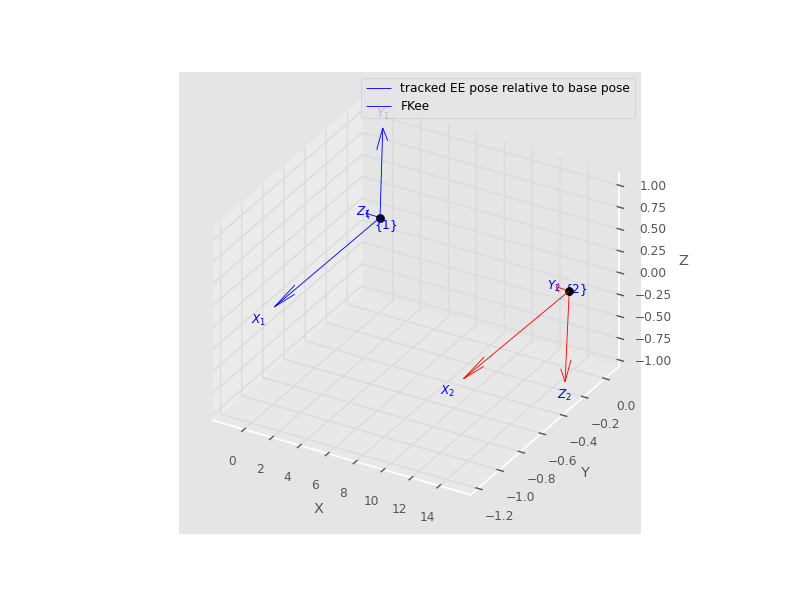

In [235]:
#SE3().plot(frame='0', color='black')
Tfinal.plot(frame='1',color='blue')
Tfk.plot(frame='2',color='red')
plt.legend(["tracked EE pose relative to base pose","FKee"])

In [265]:
marker_3d_fk = create_marker_visualization(marker, [0.2, 0.2, 0.8], Tfk.R, Tfk.t.reshape((3,1)))
marker_3d_fk.append(create_coordinate_frame_visualization(Tfk.R, Tfk.t.reshape((3,1))))
marker_3d_b = create_marker_visualization(marker, [0.2, 0.8, 0.2])
marker_3d_b.append(create_coordinate_frame_visualization(Tfinal.R, Tfinal.t.reshape((3,1))))
visualization_list3 = marker_3d_b+marker_3d_fk + [marker_mesh]

In [266]:
o3d.visualization.draw_geometries(visualization_list2+visualization_list3)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
